# Imports

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from IPython.display import SVG
from IPython.display import display 
from ipywidgets import interactive

# Helpers

In [54]:
def plot_sensor(instance=0):
  # Get instance
  random_instance = X_test[instance]

  # Print real and true values
  print("Real value:", y_test[instance])
  print("Predicted value:", y_test_preds[instance])

  # Get "weights", "bias" and "summation" variables
  weights = model.coef_
  summation = sum(weights * random_instance)
  bias = model.intercept_

  # Get and print residual
  res = ""
  if (summation + bias > 0):
    res = " > 0 -> 1"
  else:
    res = " <= 0 -> 0"
  print("Sum(weights*instance): "+str(summation)+" + Intercept (Bias): "+str(bias)+" = "+ str(summation+bias)+ res)

  # Sort weights (coefficients) by absolute value
  model_weights = pd.DataFrame({'features': list(feature_names),
                                'weights*values': list(weights * random_instance)})
  model_weights = model_weights.reindex(model_weights['weights*values'].abs().sort_values(ascending=False).index)
  model_weights = model_weights[(model_weights["weights*values"] != 0)]    

  # print number of features
  print("Number of features:",len(model_weights.values))

  # plot weights' importance as a bar plot
  plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
  sns.barplot(x="weights*values", y="features", data=model_weights)
  plt.xticks(rotation=90)
  plt.show()

# Get and Preprocess the data

In [55]:
# Get the data
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
feature_names = diabetes.feature_names

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=0, 
                                                    shuffle=True)

# Target position
TARGET_POS = -1   

# Concatenate data, so as to scale both features and the target
train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

# Scale the data
scaler = MinMaxScaler()
train_data_sc = scaler.fit_transform(train_data)
test_data_sc = scaler.transform(test_data)

# Get scaled features and the scaled target
X_train_sc = train_data_sc[:, :TARGET_POS]
y_train_sc = train_data_sc[:, TARGET_POS]
X_test_sc = test_data_sc[:, :TARGET_POS]
y_test_sc = test_data_sc[:, TARGET_POS]

print(X_train_sc.shape, X_test_sc.shape, y_train_sc.shape, y_test_sc.shape)

(309, 10) (133, 10) (309,) (133,)


# 1. White Box model

## Train a linear regression model

In [56]:
# Initialize and train linear model
model = LinearRegression()
model.fit(X_train_sc, y_train_sc)

# Get scaled predictions
y_train_preds_sc = model.predict(X_train_sc)
y_test_preds_sc = model.predict(X_test_sc)

# Unscale predictions
y_train_preds = scaler.min_[TARGET_POS] + y_train_preds_sc * scaler.data_range_[TARGET_POS]
y_test_preds = scaler.min_[TARGET_POS] + y_test_preds_sc * scaler.data_range_[TARGET_POS]

# Print results (MAE, MSE, MAPE)
print(f"***** Linear Regression Model Performance *****")
print(f"Train set: MAE = {mae(y_train, y_train_preds)}, MSE = {mse(y_train, y_train_preds)}, MAPE = {100 * mape(y_train, y_train_preds)}%")
print(f"Test set: MAE = {mae(y_test, y_test_preds)}, MSE = {mse(y_test, y_test_preds)}, MAPE = {100 * mape(y_test, y_test_preds)}%")

***** Linear Regression Model Performance *****
Train set: MAE = 47.31257664821065, MSE = 3433.0437075884915, MAPE = 36.325356417456554%
Test set: MAE = 46.12417364230234, MSE = 3461.7379665593207, MAPE = 35.170255858383044%


## Global interpretation: plot the weights (coefficient of the features = feature importance) assigned by the model to each feature

Number of features: 10


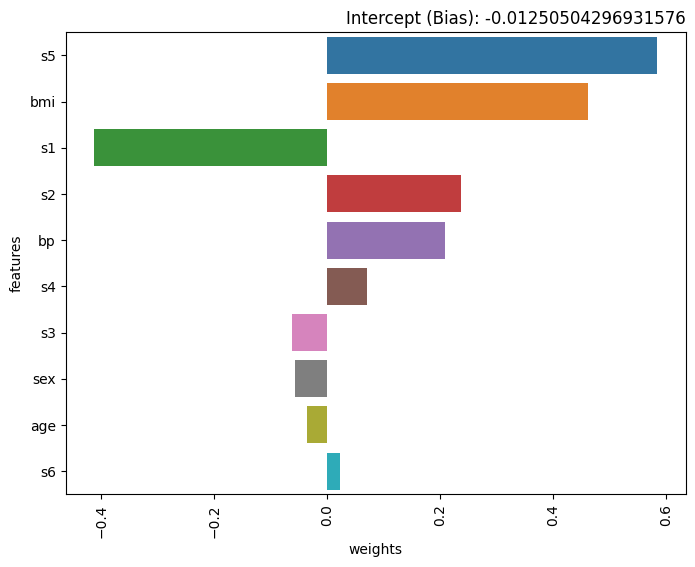

In [57]:
# Get weights
weights = model.coef_
model_weights = pd.DataFrame({'features': list(feature_names), 
                              'weights': list(weights)})

# Sort weights (coefficients) by absolute value
model_weights = model_weights.reindex(model_weights['weights'].abs().sort_values(ascending=False).index) 
model_weights = model_weights[(model_weights["weights"] != 0)]   

print("Number of features:",len(model_weights.values))

# plot weights' importance as a bar plot
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(x="weights", y="features", data=model_weights)
plt.title("Intercept (Bias): " + str(model.intercept_), loc='right')
plt.xticks(rotation=90)
plt.show()

## Local interpetation

In [58]:
inter = interactive(plot_sensor, instance=(0,9))
display(inter)

interactive(children=(IntSlider(value=0, description='instance', max=9), Output()), _dom_classes=('widget-inte…

# 2. Black Box model

## Train a Neural Network as black box model

In [59]:
# Initialize and train model
UNITS_PER_LAYER = 100
regressor = MLPRegressor(hidden_layer_sizes=(UNITS_PER_LAYER, UNITS_PER_LAYER))
regressor.fit(X_train_sc, y_train_sc)

# Get scaled predictions
y_test_preds_sc = regressor.predict(X_test_sc)

# Unscale predictions
y_test_preds = scaler.min_[TARGET_POS] + y_test_preds_sc * scaler.data_range_[TARGET_POS]

# Print results (MAE, MSE, MAPE)
print(f"***** MLP Model Performance *****")
print(f"Test set: MAE = {mae(y_test, y_test_preds)}, MSE = {mse(y_test, y_test_preds)}, MAPE = {100 * mape(y_test, y_test_preds)}%")

***** MLP Model Performance *****
Test set: MAE = 47.12270716248503, MSE = 3664.0971552905553, MAPE = 35.26724666449434%


## Obtain predictions of the black box on the training set (could perhaps better be done via cross-validation)

In [60]:
# Get scaled predictions
y_train_preds_sc = regressor.predict(X_train_sc)

# Unscale predictions
y_train_preds = scaler.min_[TARGET_POS] + y_train_preds_sc * scaler.data_range_[TARGET_POS]

# Print results (MAE, MSE, MAPE)
print(f"***** MLP Model Performance *****")
print(f"Train set: MAE = {mae(y_train, y_train_preds)}, MSE = {mse(y_train, y_train_preds)}, MAPE = {100 * mape(y_train, y_train_preds)}%")

***** MLP Model Performance *****
Train set: MAE = 45.08969234878358, MSE = 3122.288279184051, MAPE = 34.189780112953656%


## Global Surrogate models: explanation with a Linear model

In [61]:
# Initialize a linear model
linear_model = LinearRegression()

# new_X_train = X_train_sc (scaled version)
# new_y_train = y_train_preds_sc (scaled version)

# Train the model
linear_model.fit(X_train_sc, y_train_preds_sc)

# Get scaled predictions
y_test_linear_preds_sc = linear_model.predict(X_test_sc)

# Unscale predictions
y_test_linear_preds = scaler.min_[TARGET_POS] + y_test_linear_preds_sc * scaler.data_range_[TARGET_POS]

# Print results (MAE, MSE, MAPE)
print(f"***** Simple Linear Model Performance *****")
print(f"Train set: MAE = {mae(y_test, y_test_linear_preds)}, MSE = {mse(y_test, y_test_linear_preds)}, MAPE = {100 * mape(y_test, y_test_linear_preds)}%")

***** Simple Linear Model Performance *****
Train set: MAE = 46.928391003010034, MSE = 3617.3078302844347, MAPE = 35.59782459440513%


Number of features: 10


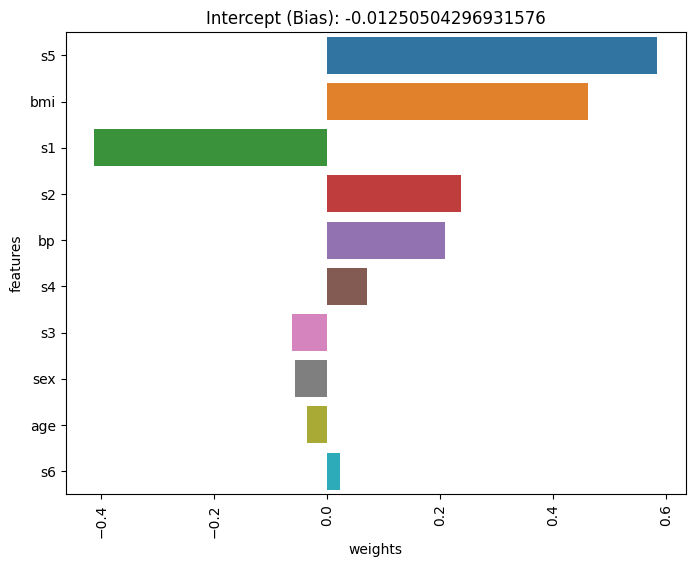

In [62]:
# Get weights
weights = model.coef_
model_weights = pd.DataFrame({'features': list(feature_names), 
                              'weights': list(weights)})

# Sort weights (coefficients) by absolute value
model_weights = model_weights.reindex(model_weights['weights'].abs().sort_values(ascending=False).index) 
model_weights = model_weights[(model_weights["weights"] != 0)]   

print("Number of features:",len(model_weights.values))

# plot weights' importance as a bar plot
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(x="weights", y="features", data=model_weights)
plt.title("Intercept (Bias): " + str(model.intercept_), loc='center')
plt.xticks(rotation=90)
plt.show()

## Local Surrogate models: explanation with a linear model

In [63]:
# Initialize a K-Neighbors model
knn_model = KNeighborsRegressor(n_neighbors=50, weights="distance", metric="minkowski", p=2)

# Fit the model on the new X_train and the new y_train
knn_model.fit(X_train_sc, y_train_preds_sc)

# Find neighbors
print("Finding Neighbors of Instance...")
instance = X_test_sc[0]
test_x = [instance]
neighbors = knn_model.kneighbors(test_x, n_neighbors=50, return_distance=False).flatten()

# Create new X's and y's
new_X_train2 = []
new_y_train2 = []
for i in neighbors:
  new_X_train2.append(X_train_sc[i])
  new_y_train2.append(y_train_preds_sc[i])

Finding Neighbors of Instance...


In [64]:
# Initialize and train a linear model
linear_model = LinearRegression()
linear_model.fit(new_X_train2, new_y_train2)

# Get scaled predictions
y_test_linear_preds_sc = linear_model.predict(X_test_sc)

# Unscale predictions
y_test_linear_preds = scaler.min_[TARGET_POS] + y_test_linear_preds_sc * scaler.data_range_[TARGET_POS]

# Display results
inter = interactive(plot_sensor, instance=(0,9))
display(inter)

interactive(children=(IntSlider(value=0, description='instance', max=9), Output()), _dom_classes=('widget-inte…